In [ ]:
import numpy as np, matplotlib.pyplot as plt
from skimage import io, color
from PIL import Image
import sys, itertools, random

In [ ]:
BLOCK_SIZE = 32

def crop_img(img):
    new_height = img.shape[0] - img.shape[0] % BLOCK_SIZE
    
    new_width = img.shape[1] - img.shape[1] % BLOCK_SIZE
    return img[:new_height,:new_width,:]

def split_img(img):
    assert img.shape[0] % BLOCK_SIZE == 0 and img.shape[1] % BLOCK_SIZE == 0
    split0 = np.split(img, img.shape[0] // BLOCK_SIZE, axis=0)
    result = []
    for x in split0:
        result += np.split(x, img.shape[1] // BLOCK_SIZE, axis=1)
    return result

def dissimilarity(e1, e2):
    return np.sqrt(np.sum((e1 - e2) ** 2))

In [ ]:
image_path = 'images/lenna.jpg'
rgb = crop_img(io.imread(image_path))
lab = color.rgb2lab(rgb)
plt.imshow(rgb)

pieces = split_img(lab)
N = len(pieces)
puzzle_height = lab.shape[0] // BLOCK_SIZE
puzzle_width = lab.shape[1] // BLOCK_SIZE
print('{} pieces'.format(len(pieces)))
right_dissimilarity = np.zeros((N, N))
down_dissimilarity = np.zeros((N, N))
for i, p1 in enumerate(pieces):
    for j, p2 in enumerate(pieces):
        right_dissimilarity[i,j] = dissimilarity(p1[:,-1], p2[:,0])
        down_dissimilarity[i,j] = dissimilarity(p1[-1,:], p2[0,:])
np.fill_diagonal(right_dissimilarity, np.inf)
np.fill_diagonal(down_dissimilarity, np.inf)

In [ ]:
best_left = np.argmin(right_dissimilarity, axis=0)
best_right = np.argmin(right_dissimilarity, axis=1)
bb_left = [x if best_right[x] == i else None for i, x in enumerate(best_left)]
bb_right = [x if best_left[x] == i else None for i, x in enumerate(best_right)]
best_up = np.argmin(down_dissimilarity, axis=0)
best_down = np.argmin(down_dissimilarity, axis=1)
bb_up = [x if best_down[x] == i else None for i, x in enumerate(best_up)]
bb_down = [x if best_up[x] == i else None for i, x in enumerate(best_down)]

In [ ]:
from enum import Enum
class Direction(Enum):
    RIGHT = 0
    DOWN = 1
    LEFT = 2
    UP = 3
    def move(self, pt):
        if self == Direction.RIGHT:
            return pt[0], pt[1] + 1
        if self == Direction.DOWN:
            return pt[0] + 1, pt[1]
        if self == Direction.LEFT:
            return pt[0], pt[1] - 1
        if self == Direction.UP:
            return pt[0] - 1, pt[1]
        raise ValueError()
    def move_reverse(self, pt):
        return Direction((self.value + 2) % 4).move(pt)

def get_random_parent():
    result = -np.ones((puzzle_height + 2, puzzle_width + 2), dtype=int)
    result[1:-1,1:-1] = np.random.choice(N, (puzzle_height, puzzle_width), replace=False)
    return result

best_buddies = {
    Direction.RIGHT : bb_right,
    Direction.LEFT : bb_left,
    Direction.UP : bb_up,
    Direction.DOWN : bb_down
}

board_cache = []
def crossover(parent1, parent2, parent1_start, parent2_start):
    parent1_loc = [None] * N
    parent2_loc = [None] * N
    child_loc = [None] * N
    for i in range(puzzle_height):
        for j in range(puzzle_width):
            a = i + parent1_start[0], j + parent1_start[1]
            b = i + parent2_start[0], j + parent2_start[1]
            parent1_loc[parent1[a]] = a
            parent2_loc[parent2[b]] = b
    
    child = -np.ones((puzzle_height * 2 + 1, puzzle_width * 2 + 1), dtype=int)
    placed = np.full(N, False, dtype=bool)
    p = np.random.randint(0, N)
    placed[p] = True
    child[puzzle_height, puzzle_width] = p
    child_loc[p] = puzzle_height, puzzle_width
    min_i = max_i = puzzle_height
    min_j = max_j = puzzle_width
    maxed_width = maxed_height = False
    
    def delete_width_violation(dict_):
        for r in [(i, j) for i, j in dict_ if j > max_j or j < min_j]:
            print('deleted', r)
            del dict_[r]
            
    def delete_height_violation(dict_):
        for r in [(i, j) for i, j in dict_ if i > max_i or i < min_i]:
            print('deleted', r)
            del dict_[r]
    
    def helper(ij, p):
        nonlocal min_i, max_i, min_j, max_j, maxed_width, maxed_height
        board_cache.append((child.copy(), child_loc.copy(), min_i, min_j, max_i, max_j, ij))
        print(p, ij)
        child[ij] = p
        child_loc[p] = ij
        i, j = ij
        placed[p] = True
        min_i = min(min_i, i)
        max_i = max(max_i, i)
        min_j = min(min_j, j)
        max_j = max(max_j, j)
        if not maxed_width and max_j - min_j == puzzle_width - 1: # first piece that spans the entire width
            print('========== width achieved')
            list(map(delete_width_violation, [unchecked, parent_with_best_bud, remaining]))
            maxed_width = True
        if not maxed_height and max_i - min_i == puzzle_height - 1: # first piece that spans the entire width
            print('========== height achieved')
            list(map(delete_height_violation, [unchecked, parent_with_best_bud, remaining]))
            maxed_height = True
        if max_j - min_j >= puzzle_width or max_i - min_i >= puzzle_height:
            raise RuntimeError()
         
        dirs = []
        if not maxed_width: # hasn't maxed width yet, append both
            dirs.extend([Direction.LEFT, Direction.RIGHT])
        else:
            if j > min_j: dirs.append(Direction.LEFT)
            if j < max_j: dirs.append(Direction.RIGHT)
        
        if not maxed_height:
            dirs.extend([Direction.UP, Direction.DOWN])
        else:
            if i > min_i: dirs.append(Direction.UP)
            if i < max_i: dirs.append(Direction.DOWN)
        print(dirs)
        for d2 in dirs:
            new_empty = d2.move(ij)
            if child[new_empty] == -1 and new_empty not in unchecked:
                unchecked[new_empty] = (d2, p)
                
    # location of empty slot => (direction from existing slot to empty slot, piece number of existing slot)
    unchecked = {d.move((puzzle_height, puzzle_width)): (d, p) for d in Direction}
    # location of empty slot => (direction from existing slot to empty slot, piece number of existing slot, piece number of buddy)
    parent_with_best_bud = {}
    # location of empty slot => (direction from existing slot to empty slot, piece number of existing slot)
    remaining = {}
    while unchecked or parent_with_best_bud or remaining:
        while unchecked:
            ij = random.choice(list(unchecked.keys())) # TODO: optimize this selection (maybe make this datastructure a list and shuffle periodically)
            d, p = unchecked.pop(ij)
            p1_l = parent1_loc[p]
            p2_l = parent2_loc[p]
            loc1 = d.move(p1_l)
            loc2 = d.move(p2_l)
            p1 = parent1[loc1]
            p2 = parent2[loc2]
            if p1 >= 0 and p1 == p2 and not placed[p1]:
                helper(ij, p1)
                continue
            bb = best_buddies[d][p]
            if p1 == bb and not placed[p1]:
                parent_with_best_bud[ij] = (d, p, p1)
            elif p2 == bb and not placed[p2]:
                parent_with_best_bud[ij] = (d, p, p2)
            else:
                remaining[ij] = (d, p)
        while parent_with_best_bud:
            ij = random.choice(list(parent_with_best_bud.keys())) # TODO: optimize this selection (maybe make this datastructure a list and shuffle periodically)
            d, p, p_new = parent_with_best_bud.pop(ij)
            if child[ij] == -1 and not placed[p_new]:
                helper(ij, p_new)
                break
        else:
            while remaining:
                ij = random.choice(list(remaining.keys())) # TODO: optimize this selection (maybe make this datastructure a list and shuffleperiodically)
                d, p = remaining.pop(ij)
                if child[ij] == -1:
                    if d == Direction.DOWN:
                        diss = down_dissimilarity[p]
                    elif d == Direction.UP:
                        diss = down_dissimilarity[:, p]
                    elif d == Direction.RIGHT:
                        diss = right_dissimilarity[p]
                    elif d == Direction.LEFT:
                        diss = right_dissimilarity[:, p]
                    else: raise RuntimeError()
                    placed_diss = diss + placed * sys.maxsize
                    p_new = np.argmin(placed_diss)
                    helper(ij, p_new)
                    break
    return child, child_loc, min_i, min_j
            
child, child_loc, min_i, min_j = crossover(get_random_parent(), get_random_parent(), (1, 1), (1, 1))

In [59]:
def crop(puzz, min_i, min_j, max_i=None, max_j=None):
    if max_i is None: max_i = min_i + puzzle_height - 1
    if max_j is None: max_j = min_j + puzzle_width - 1
    return puzz[min_i : max_i + 1, min_j : max_j + 1]

def print_board(board, min_i, min_j, max_i, max_j):
    form = lambda x: '%4d' % x
    print(min_i, max_i, min_j, max_j)
    print('\n'.join([''.join(map(form, row)) for row in crop(board, min_i, min_j, max_i, max_j)]))

def check(arrangement, piece_loc, min_i, min_j):
    cropped = crop(arrangement, min_i, min_j)
    assert np.sum(cropped == -1) == 0
    assert cropped.size == len(set(cropped.flatten()))
    for p, loc in enumerate(piece_loc):
        assert arrangement[piece_loc[p]] == p
    
def reassemble(pieces, arrangement, min_i, min_j):
    return np.concatenate(
        [np.concatenate([pieces[p] for p in row], axis=1) for row in crop(arrangement, min_i, min_j)],
        axis=0
    )
# board, _, min_i, min_j, max_i, max_j, ij = board_cache[-1]
# print_board(board, min_i, min_j, max_i, max_j)
# print_board(child, min_i, min_j, min_i + puzzle_height - 1, min_j + puzzle_width - 1)
check(child, child_loc, min_i, min_j)
reassembled = reassemble(pieces, child, min_i, min_j)

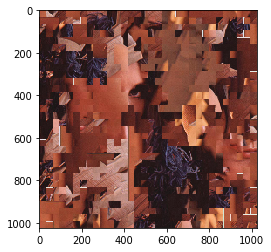

In [60]:
plt.imshow(color.lab2rgb(reassembled))
plt.show()

In [ ]:

#     for p in unplaced:
#         i1, j1 = parent1_loc[p]
#         i2, j2 = parent2_loc[p]
#         right1 = i1, j1 + 1
#         right2 = i2, j2 + 1
#         c = parent1[right1]
#         if c >= 0 and c == parent2[right2]:
#             child[min_i, min_j] = p
#             child[min_i, min_j + 1] = c
#             max_j += 1
#             unplaced.remove(p)
#             unplaced.remove(c)
#             break
#         down1 = i1 + 1, j1
#         down2 = i2 + 1, j2
#         c = parent1[down1]
#         if c >= 0 and c == parent2[down2]:
#             child[min_i, min_j] = p
#             child[min_i + 1, min_j] = c
#             max_i += 1
#             unplaced.remove(p)
#             unplaced.remove(c)
#             break
#     else:
#         # found no parent agreements